# SARIMAX model

In this notebook, we present our **SARIMAX model**, which integrates temperature as an exogenous variable to improve forecasting accuracy beyond that of the MSTL-based approach. The entire modeling pipeline is encapsulated within the `SARIMAXPipeline` class.

**Key Features of the Model**

* The model leverages exogenous variables—such as climate data or calendar-based indicators—for the linear regression component, while modeling the residuals with a SARIMA process.
* **Daily seasonality** is captured through the SARIMA residual component, providing a flexible structure that can adapt over time, in contrast to fixed-pattern approaches like Fourier terms.
* **Weekly seasonality** is explicitly represented using exogenous Fourier terms, enabling the model to effectively account for regular weekly patterns.
* **Longer-term (e.g., annual) seasonality** is modeled through the temperature exogenous variable, capturing the influence of climate-driven trends.



## Import libreries and data

Use version 2.2 of Numpy or less for compatibility with Numba.

In [1]:
import sys, numpy, numba
print("Python      :", sys.version.split()[0])
print("NumPy       :", numpy.__version__)
print("Numba       :", numba.__version__)

Python      : 3.12.9
NumPy       : 2.2.6
Numba       : 0.61.2


In [2]:
import subprocess
from pathlib import Path

# Detect if running on Google Colab
def in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

# Set base directory and handle environment
if in_colab():
    # Install required packages only if not already installed
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for pkg in ["statsmodels", "statsforecast", "mlforecast"]:
        install(pkg)

    # Mount Google Drive
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')

    # Set base directory to your Drive project folder
    BASE_DIR = Path('/content/drive/MyDrive/heat-forecast')

    # Add `src/` to sys.path for custom package imports
    src_path = BASE_DIR / 'src'
    if str(src_path) not in sys.path:
        sys.path.append(str(src_path))

else:
    # Local/VM setup: assume notebook is in project_root/notebooks/
    BASE_DIR = Path.cwd().parent

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose, MSTL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsforecast import StatsForecast
from statsforecast.utils import ConformalIntervals
from statsforecast.models import AutoETS, SeasonalNaive, AutoARIMA, ARIMA, Naive
from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression
from utilsforecast.feature_engineering import fourier, pipeline 
import yaml

# Tell SafeDumper to treat Python tuples as ordinary sequences
def _tuple_representer(dumper, data):
    return dumper.represent_sequence(
        yaml.resolver.BaseResolver.DEFAULT_SEQUENCE_TAG,
        list(data)
    )
yaml.SafeDumper.add_representer(tuple, _tuple_representer)

import os, stat

def _on_rm_error(func, path, exc_info):
    # called if shutil.rmtree fails (e.g. file is read-only)
    os.chmod(path, stat.S_IWRITE)  # remove read-only flag
    func(path)

from typing import Callable, Dict, Optional, List, Any, Union, Tuple, Sequence, Iterable
from coreforecast.scalers import boxcox, boxcox_lambda, inv_boxcox
import matplotlib.dates as mdates
from datetime import datetime
import warnings
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%H:%M:%S",
    force=True             
)

from itertools import product
from functools import partial, reduce
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
import time
import pickle
from pathlib import Path
import shutil

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler
palette = sns.color_palette("tab10", 5) # Color palette for different IDs
plt.rcParams['font.size'] = 14 
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
plt.rcParams['axes.titlesize'] = 16        # Title of the plot
plt.rcParams['axes.labelsize'] = 14        # X and Y axis labels
plt.rcParams['xtick.labelsize'] = 10       # X tick labels
plt.rcParams['ytick.labelsize'] = 10       # Y tick labels
plt.rcParams['legend.fontsize'] = 10       # Legend text
plt.rcParams['figure.titlesize'] = 18      # Figure title
mpl.rcParams['axes.grid']        = True
mpl.rcParams['axes.grid.which']  = 'both'  # draw grid on both major and minor ticks

from heat_forecast.utils.datasplit import generate_sets
from heat_forecast.utils.transforms import get_lambdas, make_transformer, transform_column
from heat_forecast.utils.plotting import configure_time_axes, custom_plot_results, plot_cutoff_results, scatter_temp_vs_target_hourly
from heat_forecast.utils.decomposition import decompose_annual_seasonality, remove_annual_component, add_annual_component
from heat_forecast.utils.evaluation import (
    custom_evaluate, display_metrics, custom_evaluate_cv, display_cv_summary, barplot_cv, plot_cv_metric_by_cutoff,
    compute_loss_diff_stats, adj_r2_score, aic_score, aicc_score, bic_score, overforecast_over_th_score, underforecast_over_th_score
)
from heat_forecast.utils.cv_utils import get_cv_params, get_cv_params_for_test, display_info_cv 

from heat_forecast.pipeline import SARIMAXPipeline, SARIMAXConfig

Import pre-elaborated data.

In [4]:
heat_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'heat.csv'
aux_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'auxiliary.csv'
heat_df = pd.read_csv(heat_path, parse_dates=['ds'])
aux_df = pd.read_csv(aux_path, parse_dates=['ds'])

## Exploring the relationship between temperature and target variable

An important initial step in building the model is identifying potentially informative exogenous variables. This analysis will be performed on a per-series basis.

In [5]:
# Choose a single unique_id
id = 'F1'

As an initial exploration, we plot heat demand against temperature, with each point colored by the corresponding hour of the day. For each hour (i.e., each color), the plot includes two regression lines: one fitted using data from the "winter" period (defined as mid-November to the end of March), and the other using data from the "non-winter" period.

In [6]:
heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
aux_id_df = aux_df[aux_df['unique_id'] == id].copy()

corr_df = scatter_temp_vs_target_hourly(
    target_df=heat_id_df,
    aux_df=aux_id_df,
    date_range=pd.date_range(start='2022-05-01', end='2024-05-01', freq='h'),
)

# Display the correlation dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Correlation by season and hour:")
    display(
        corr_df.style
        .background_gradient(cmap='Blues', axis=None, gmap=corr_df.abs(), vmax=1.0, vmin=0.0)  # Add a blue gradient
        .format(precision=2)
        .set_caption("Correlation between Temperature and Heat Demand by Season and Hour")
    )


Correlation by season and hour:


Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Season,,,,,,,,,,,,,,,,,,,,,,,,
Non-Winter,-0.77,-0.77,-0.75,-0.74,-0.71,-0.68,-0.69,-0.67,-0.69,-0.71,-0.72,-0.72,-0.71,-0.70,-0.69,-0.69,-0.71,-0.72,-0.72,-0.73,-0.72,-0.74,-0.77,-0.76
Winter,-0.85,-0.85,-0.85,-0.82,-0.79,-0.81,-0.78,-0.78,-0.81,-0.86,-0.89,-0.89,-0.88,-0.87,-0.86,-0.86,-0.89,-0.90,-0.92,-0.92,-0.92,-0.91,-0.85,-0.86


The figure reveals a distinct difference in the temperature–demand relationship between winter and non-winter, underscoring the importance of explicitly accounting for this seasonal separation. This finding aligns with intuition, given that the target variable reflects heat demand. Additionally, in winter, the slope of the regression line varies noticeably by hour, indicating that daily seasonality is not driven solely by temperature. This again is expected, as human behavior plays a major role in shaping daily heating patterns. However, this complexity in daily seasonality will be addressed later by the SARIMAX residual component, so for now we focus on the winter/non-winter separation.

A closer analysis of the target variable suggested a more dynamic approach to capturing seasonal separation. Rather than relying on fixed calendar-based "winter" periods, we define the start and end of the cold season based on recent temperature trends. Specifically, a timestamp is classified as part of the "cold semester" if the average temperature over the preceding four days falls below a certain threshold. This threshold is tuned individually for each time series, allowing for a more responsive and data-driven delineation of seasonal behavior.

## Data preparation

The `SARIMAXPipeline.prepare_data` method provides a flexible framework for configuring exogenous variables, making it easy to experiment with and compare different modeling strategies. The supported exogenous inputs fall into two primary categories:

* **Climate-based variables**, sourced from the `aux_df` dataset (e.g., temperature).
* **Seasonal Fourier terms**, used to capture periodic patterns such as daily or weekly seasonality.

The table below summarizes all available options for preparing these exogenous features, which constitute the majority of parameters within the `SARIMAXConfig`.

> **Basic Configuration**
>
> * **`with_exog`**: Toggles the inclusion of exogenous variables.
> * **`exog_vars`**: List of column names from `aux_df` to use as exogenous inputs (e.g., `['temperature', 'dew_point']`). If `with_exog=True`, `temperature` **must** be included, as it is used to distinguish
between cold and warm seasonal regimes.
>
>**Transformations of Temperature**
>
>* **`temp_transform`**: Enables a piecewise-sigmoid transformation for temperature.
>* **`threshold`, `lower_asymptote`, `upper_asymptote`, `k`, `k_right`**: Parameters for the piecewise-sigmoid function, used to model saturation or diminishing returns in temperature effects.
>
>**Cold vs. Non-Cold Period Handling**
>
>* **Automatic cold period detection**: A point is labeled “cold” if the 4-day moving average temperature falls below the defined `threshold`.
>* **`is_cold`**: A derived binary indicator used to distinguish cold and non-cold periods.
>* **`k_week_only_when_cold`**: If `True`, weekly Fourier terms are only applied during cold periods, based on the `is_cold` flag.
>
>**Fourier-Based Seasonality**
>
>* **`k_week`**: Number of Fourier terms for modeling **weekly** seasonality (168-hour cycles).
>* **`k_day`**: Number of Fourier terms for modeling **daily** seasonality (24-hour cycles).
>
>**Lagged and Aggregated Features**
>
>* **`drop_hourly_exog`**: If `True`, raw hourly features are discarded after generating lagged or aggregated versions.
>* **`lags_exog`**: List of lag offsets (e.g., `[1, 24, 48]`) to include past values of selected exogenous variables. Ignored if `drop_hourly_exog=True`.
>* **`days_averages` / `max_lag_daily_agg`**: Computes multi-day rolling averages with optional lags (e.g., 3-day mean temperature).
>* **`hours_averages` / `max_lag_hourly_agg`**: Similar to above but over shorter hourly windows (e.g., 6-hour average).
>
>**Peak Hour Splits**
>
>* **`use_is_peak`**: If enabled, both climate-based and high-frequency features are split into `*_peak` and `*_offpeak` variants based on defined peak hours.
>* **`peak_hours`**: List of hours considered peak demand times (e.g., `[6, 7]`). Defaults to per-series selections if not specified.
>
>**Cold/Warm Feature Duplication**
>
>* When `with_exog = True`, all exogenous variables and Fourier terms are duplicated into `*_cold` and `*_warm` versions based on the `is_cold` label.
>* This setup allows the model to learn **season-specific effects**, enabling distinct feature sets for cold and warm periods.
>


The `piecewise_sigmoid` function for temperature transformation models a smooth, S-shaped curve that transitions from a lower bound to an upper bound, centered at a midpoint. It consists of two logistic curves joined at the midpoint `mid`, and is continuous (and optionally smooth in its first derivative) at that point.

Precisely:
$$
f(x) =
\begin{cases}
\ell + \dfrac{2(m - \ell)}{1 + e^{-k_L(x - m)}} & \text{if } x \leq m \\
u - \dfrac{2(u - m)}{1 + e^{k_R(x - m)}} & \text{if } x > m
\end{cases}
$$

where:
- $ \ell $ is the `lower_asymptote`;
- $ u $ is the `upper_asymptote`;
- $ m $ is the midpoint `mid`;
- $ k_L $ is `k_left` and controls the slope of the left sigmoid;
- $ k_R $ is `k_right` and controls the slope of the right sigmoid (optional). 

If `k_right` is not specified, it defaults to:
$$
k_R = k_L \cdot \frac{m - \ell}{u - m},
$$
ensuring the first derivative is continuous at $x = m$. 

$k_L$ and $k_R$ can be interpreted as steepness factors as:
$$
f'(m^-) = \frac{(m - \ell) \cdot k_L}{2},  \quad f'(m^-) = \frac{(m - \ell) \cdot k_L}{2} 
$$

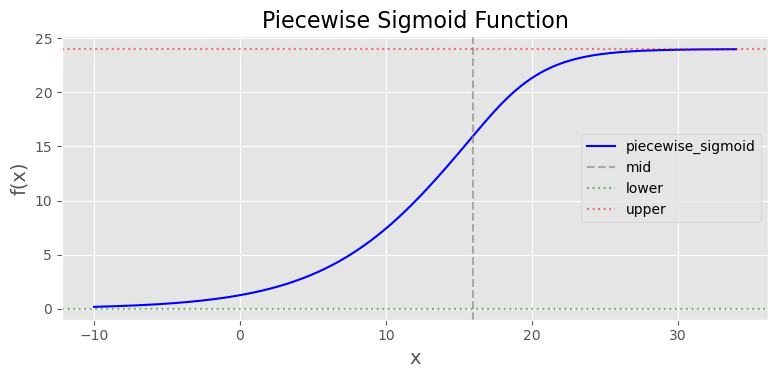

In [7]:
def piecewise_sigmoid(x, mid, lower, upper, k_left=0.5, k_right=None):
    if not (lower < mid < upper):
        raise ValueError("Must satisfy: lower < mid < upper")
    
    x = np.asarray(x)

    if k_right is None:
        k_right = k_left * (mid - lower) / (upper - mid)

    left_piece = lower + 2*(mid - lower) / (1 + np.exp(-k_left * (x - mid)))
    right_piece = upper - 2*(upper - mid) / (1 + np.exp(k_right * (x - mid)))
    
    result = np.where(x <= mid, left_piece, right_piece)
    return result.item() if result.ndim == 0 else result


# --- Visualization ---
def plot_piecewise_sigmoid(mid=16, lower=0, upper=24, k_left=0.2, k_right=None):
    x_vals = np.linspace(lower - 10, upper + 10, 500)
    y_vals = piecewise_sigmoid(x_vals, mid=mid, lower=lower, upper=upper, k_left=k_left, k_right=k_right)

    plt.figure(figsize=(8, 4))
    plt.plot(x_vals, y_vals, label='piecewise_sigmoid', color='blue')
    plt.axvline(mid, color='gray', linestyle='--', alpha=0.6, label='mid')
    plt.axhline(lower, color='green', linestyle=':', alpha=0.5, label='lower')
    plt.axhline(upper, color='red', linestyle=':', alpha=0.5, label='upper')
    plt.title("Piecewise Sigmoid Function")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Try the default parameters ---
plot_piecewise_sigmoid()


The `SARIMAXPipeline.prepare_data` method also supports transforming the target variable (`y`). This can help stabilize variance and improve model performance.

> **Target Transformation Options**
>
> * **`transform`**: Specifies the transformation applied to the target variable. Options include:
>   - `"none"` or `None`: No transformation.
>   - `"log"` or `"arcsinh"`: Standard transformations for stabilizing variance.
>   - `"boxcox"`: Applies the Box-Cox transformation with λ estimated from the full training target series.
>   - `"boxcox_winter"`: Box-Cox transformation with λ estimated only from winter periods (typically mid-November to March).
>   - `"boxcox_cold"`: Box-Cox transformation with λ estimated from observations labeled as cold (`is_cold=True`).
>
> * **`lam_method`**: Specifies the method for estimating the Box-Cox λ parameter. Options:
>   - `"loglik"`: Maximum likelihood estimation.
>   - `"guerrero"`: Minimizes the coefficient of variation across groups.
>
> * **`is_winter`**: Optional custom function for defining "winter" periods used in the `boxcox_winter` setting.

## Fine tuning

### Choosing an appropriate threshold

A first, crucial parameter to choose is the `threshold` parameter (for seasonal separation, explained above). To choose it, we perform a simple linear regression, regressing the target variable with the temperature with cold/warm seasonal separation (i.e., only three variables: `temperature_cold`, `temperature_warm` and the binary `is_cold`), and see which threshold works best.

In [7]:
# Pick an id and a candidate threshold 
id = 'F1'
threshold = 13 # Example threshold

par = { # Added 7-day averages, 1 lag of temperature, separation using peak hours
    'k_week': 5,
    'threshold': 13,
    'exog_vars': ['temperature', 'humidity'],
    'days_averages': [1, 4],
    'drop_hourly_exog': False,
    'lags_exog': [1],
    'use_peak_hours': True,  
    'sarima_kwargs': {
        'order': (1, 0, 0),
        'season_length': 24,
        'seasonal_order': (1, 1, 1)
    }
}

# Initialize configuration for the desired data preparation
sconfig = SARIMAXConfig(
    **par
)

# Create the SARIMAX pipeline with the specified configuration and generate the data
heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_id_df,
    aux_df=aux_id_df,
    config=sconfig,
)
spipeline.prepare_data()
prepared_data = spipeline.prepared_data

spipeline.describe_prepared_data()
    

22:20:28 | INFO | heat_forecast.pipeline.sarimax | Prepared data description:
Unique id: F1
Using target transform: boxcox_cold
Using a temperature transform?: false
data:
    shape: (51599, 28)
    columns:
        basic:
        - unique_id
        - ds
        - y
        climate-based:
        - temperature_1days_avg_cold
        - humidity_1days_avg_cold
        - temperature_4days_avg_cold
        - humidity_4days_avg_cold
        - temperature_1days_avg_warm
        - temperature_cold_peak
        - humidity_cold_peak
        - temperature_lag1_cold_peak
        - humidity_lag1_cold_peak
        - temperature_cold_offpeak
        - humidity_cold_offpeak
        - temperature_lag1_cold_offpeak
        - humidity_lag1_cold_offpeak
        - is_cold
        - is_peak
        fourier: []
    start_date: '2019-07-01 01:00:00'
    end_date: '2025-05-19 23:00:00'



00:35:51 | INFO | root | Results for threshold 13 and unique_id F1:
00:35:51 | INFO | root | > Adjusted R^2 score  : 0.902
00:35:51 | INFO | root | > AICc score          : 106165.172
00:35:51 | INFO | root | > ME at-peak score    : 0.000
00:35:51 | INFO | root | > Underforecast score : 0.000


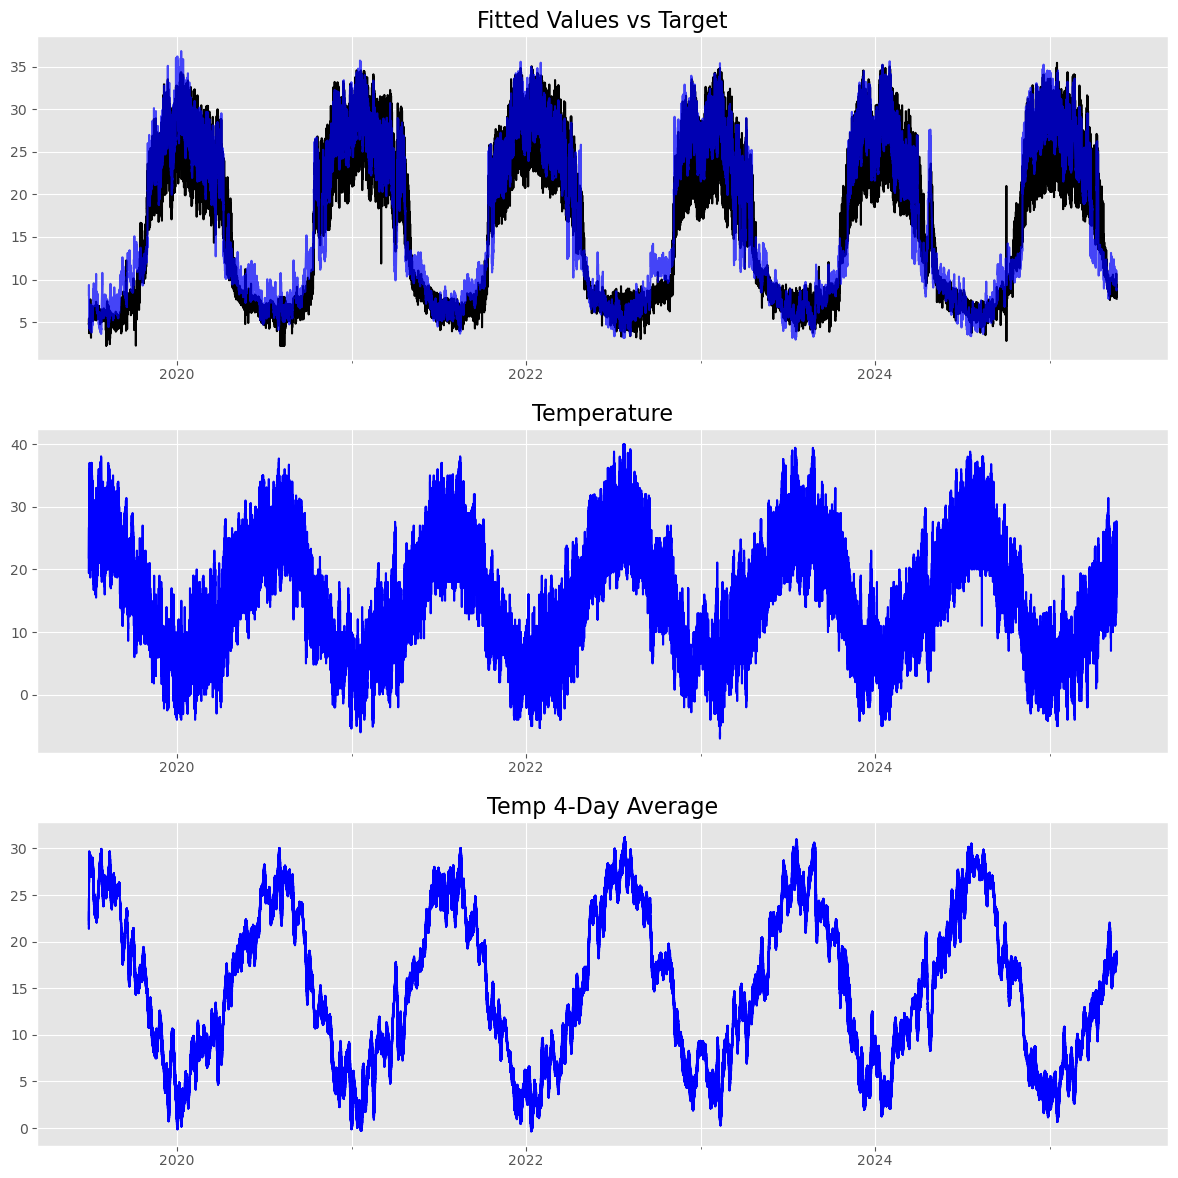

In [ ]:
mf = MLForecast(models=LinearRegression(), freq="h")

# Fit model
mf.fit(prepared_data, fitted=True, static_features=[])

# Get fitted values and calculate evaluation metrics
fitted_values = mf.forecast_fitted_values()
insample_forecasts = fitted_values['LinearRegression']
insample_y = prepared_data['y']

T = len(insample_y)
K_par = len(mf.models_["LinearRegression"].coef_) # Number of parameters in the linear model

logging.info(f"Results for threshold {threshold} and unique_id {id}:")
logging.info(f"> Adjusted R^2 score  : {adj_r2_score(insample_y, insample_forecasts, T, K_par):.3f}")
logging.info(f"> AICc score          : {aicc_score(insample_y, insample_forecasts, T, K_par):.3f}")
logging.info(f"> ME at-peak score    : {mae_over_thr_score(insample_y, insample_forecasts, y_th=100):.3f}")
logging.info(f"> Underforecast score : {underforecast_over_th_score(insample_y, insample_forecasts, y_th=100):.3f}")

# plot the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.flatten()

axes[0].plot(prepared_data['ds'], insample_y, label='Transformed Target', color='black', alpha=1.0)
axes[0].plot(fitted_values['ds'], insample_forecasts, label='Fitted Values', color='blue', alpha=0.7)
axes[0].set_title('Fitted Values vs Target')

filtered_aux_train_df = aux_df.loc[
    aux_df['ds'].isin(prepared_data['ds']), 
    ['ds', 'unique_id', 'temperature']
]
filtered_aux_train_df.sort_values(by='ds', inplace=True)

axes[1].plot(filtered_aux_train_df['ds'], filtered_aux_train_df['temperature'], label='Temperature', color='blue', alpha=1.)
axes[1].set_title('Temperature')

filtered_aux_train_df['temp_fewdays_avg'] = (
    filtered_aux_train_df
    .groupby('unique_id')['temperature']
    .rolling(window=24*4, min_periods=1)  
    .mean()
    .reset_index(0, drop=True)
)

axes[2].plot(filtered_aux_train_df['ds'], filtered_aux_train_df['temp_fewdays_avg'], label='Temp 4-Day Avg', color='blue', alpha=1.)
axes[2].set_title('Temp 4-Day Average')

configure_time_axes(axes, prepared_data['ds'])

fig.tight_layout()

In [8]:
best_thresholds = {
    'F1': 13.5,
    'F2': 13.8,
    'F3': 13.8,
    'F4': 12.8,
    'F5': 13.8,
}

### Choosing temperature and target transformations

After selecting an appropriate threshold, the second step involves choosing suitable transformations for both the target and the temperature variables. We adopt the following strategy:

- **No transformation of temperature**: We opt to use raw temperature values, as the time series do not show evidence of saturation effects on the cold side — i.e., there is no visible plateau in heat demand at very low temperatures. Additionally, potential saturation effects on the warm side are already accounted for by the seasonal (cold/warm) separation in the modeling pipeline.

- **Box-Cox transformation of the target variable with option `boxcold_cold`**: This transformation is applied to the target variable specifically during the 'cold' period to stabilize its variance and reduce oscillations. This is particularly important because the Fourier terms used to model seasonality are also split by cold and warm seasons, and we want to enhance their ability to capture consistent seasonal patterns during colder periods.

### Choosing climate-based features and SARIMA parameters

Performing an exhaustive grid search over SARIMA parameters is impractical due to prohibitively long training times. Instead, we adopt a more efficient, staged approach:

* **Step 1:** Fix a promising SARIMA structure for the residuals based on early experimentation. In our case, many initial tests pointed to:

  $$
  \text{SARIMA}((p, d, q), 24, (P, D, Q)) = \text{SARIMA}((1, 0, 0), 24, (1, 1, 1))
  $$

  as a robust starting point.

* **Step 2:** Run cross-validation using different parameter combinations, incrementally increasing model complexity.

* **Step 3 (Optional):** After identifying the best-performing parameters, optionally run an AutoARIMA procedure to search for improved SARIMA configurations based on those settings. If better models are found, repeat the cross-validation process.

In practice, however, even with AutoARIMA, we did not observe significant performance improvements over the manually selected model above. Given the high computational cost and minimal gain, we opted to skip the final refinement step.

In [22]:
finetune = True  # Set to False to skip fine-tuning

 # Forecast horizon in hours (1 week). We only use this forecast horizon for fine-tuning
            # because it allows as to consider less windows and since we are testing a very limited set of parameters
            # in which we study the effectiveness of different variables in explaining the target,
            # we don't expect to get meaningfully different results with shorter horizons

# Note: by default we have:
# - `tranform`='boxcox_cold';
# - `lam_method`='loglik';
# - `k_week_only_when_cold`=True;

all_params = [
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'exog_vars': ['temperature'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'exog_vars': ['temperature'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'exog_vars': ['temperature', 'humidity'],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'exog_vars': ['temperature', 'humidity'],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'exog_vars': ['temperature', 'humidity', 'pressure'],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'exog_vars': ['temperature', 'humidity', 'pressure'],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': True, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    { # Simplest parameters, should still work fairly well for all facilities
        'k_week': 5,
        'threshold': best_thresholds[id],
        'days_averages': [1, 4],
        'exog_vars': ['temperature', 'humidity', 'pressure', 'wind_speed'],
        'drop_hourly_exog': False,
        'lags_exog': None,
        'use_peak_hours': False, 
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
]

if finetune:
    # ------------- Choose parameters for cross-validation -------------
    # Save partial results?
    save_partials = True  # Set to False to save only the final results
    # For get_cv_params:
    n_windows = 15  
    h = 168  # Forecast horizon in hours (1 week)
    start_test_cv = pd.to_datetime('2023-11-15')
    end_test_cv = pd.to_datetime('2024-04-01')
    # For fitting furing cross-validation:
    input_size = 365*24  # Number of hours to consider for each training

    metadata = {f'params_set_{i}': all_params[i] for i in range(len(all_params))}
    metadata['for_get_cv_params'] = {
        'n_windows': n_windows,
        'forecast_horizon': h,
        'start_test_cv': str(start_test_cv),
        'end_test_cv': str(end_test_cv),
    }
    metadata['input_size'] = input_size

    # ------------- Create directory for fine-tuning results -------------
    timestamp = datetime.now().strftime("%Y%m%dT%H%M%S")
    run_id = f"{id}_finetuning_sarimax_{timestamp}"
    path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
    metadata['run_id'] = run_id

    try:
        path.mkdir(parents=True, exist_ok=False)
        logging.info(f"Created directory for fine-tuning results: {path.relative_to(BASE_DIR)}")

        # ------------- Set windows with get_cv_params -------------  
        step_size, test_hours, end_test_cv = get_cv_params(
            start_test_cv=start_test_cv,  
            end_test_cv=end_test_cv,    
            n_windows=n_windows,  
            horizon_hours=h,  
        )

        # ------------- Run CV once with the naive model for comparison -------------
        naive_model = SeasonalNaive(season_length=24, alias='Naive24h')
        sf = StatsForecast(models=[naive_model], freq='h')
        full_df = heat_id_df[heat_id_df['ds'] <= end_test_cv]  # Use all data up to the end of the last forecast horizon
        t0 = pd.Timestamp.now()
        cv_naive = sf.cross_validation(
            h=h,
            df=full_df,
            n_windows=n_windows,
            step_size=step_size,  
            test_size=test_hours,  
            input_size=None,  
            refit=True,  
        )
        t1 = pd.Timestamp.now()
        elapsed = (t1 - t0).total_seconds()
        params_placeholder = {key: None for key in all_params[0].keys()}
        params_except_sarima = {k:v for k,v in params_placeholder.items() if k != 'sarima_kwargs'}
        record = {
            'name': 'Naive24h',
            'avg_elapsed_sec': elapsed/n_windows,  
            **params_except_sarima,  # Don't need to retain the SARIMA parameters for records
        }

        # store results and corresponding params / name of the model / elapsed time
        records = [record]  
        cv_frames = [cv_naive]

        # ------------- Run grid search for MSTL model -------------
        aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
        t_start_cv = pd.Timestamp.now()
        for i, params in enumerate(tqdm(all_params, desc="Grid search", leave=True)):

            sconfig = SARIMAXConfig(**params)
            spipeline = SARIMAXPipeline(
                target_df=heat_id_df,
                aux_df=aux_id_df,
                config=sconfig,
            )
            t0 = pd.Timestamp.now()
            cv_sarimax = spipeline.cross_validation(
                h=h,                   # Forecast horizon in hours
                test_size=test_hours,  # Test size in hours
                end_test=end_test_cv,  # End of the test period
                step_size=step_size,   # Step size in hours
                input_size=input_size,     # Number of hours to consider for each training
                verbose=False,
                alias=f'SARIMAX_{i}',  # Alias for the model
            )
            t1 = pd.Timestamp.now()
            elapsed = (t1 - t0).total_seconds()
            cv_sarimax.drop(columns=['y'], errors='ignore', inplace=True)
            cv_frames.append(cv_sarimax)

            params_except_sarima = {k:v for k,v in params.items() if k != 'sarima_kwargs'}
            record = {
                'name': f'SARIMAX_{i}',  
                'avg_elapsed_sec': elapsed/n_windows,
                **params_except_sarima,  
            }
            records.append(record)

            if save_partials:
                key_cols = ["unique_id", "ds", "cutoff"]
                cv_results_df = reduce(
                    lambda left, right: pd.merge(left, right, on=key_cols, how="outer"),
                    cv_frames            
                )
                records_df = pd.DataFrame(records)
                results = (records_df, cv_results_df)

                t_end_cv = pd.Timestamp.now()
                elapsed_cv = str(t_end_cv - t_start_cv)
                metadata['total_elapsed_time'] = elapsed_cv

                # ------------- save -------------
                records_df.to_parquet(path / "records.parquet", compression="snappy")
                cv_results_df.to_parquet(path / "cv_results.parquet", compression="snappy")

        # ------------- Combine all cross-validation results into a single DataFrame -------------
        key_cols = ["unique_id", "ds", "cutoff"]
        cv_results_df = reduce(
            lambda left, right: pd.merge(left, right, on=key_cols, how="outer"),
            cv_frames            
        )
        records_df = pd.DataFrame(records)
        results = (records_df, cv_results_df)

        t_end_cv = pd.Timestamp.now()
        elapsed_cv = str(t_end_cv - t_start_cv)
        metadata['total_elapsed_time'] = elapsed_cv

        # ------------- Final save -------------
        records_df.to_parquet(path / "records.parquet", compression="snappy")
        cv_results_df.to_parquet(path / "cv_results.parquet", compression="snappy")

        metadata_path = path / 'metadata.yaml'
        with open(metadata_path, 'w') as f:
            yaml.safe_dump(
                metadata,
                f,
                indent=4,                    # indentation for nested structures
                default_flow_style=False,    # block style
                sort_keys=False              # preserve insertion order
            )

        logging.info("✓ All artifacts saved successfully, fine-tuning completed.")

    except KeyboardInterrupt:
        if not save_partials:
            logging.warning("✗ Fine-tuning interrupted by user, cleaning up.")
            shutil.rmtree(path, onexc=_on_rm_error)
            logging.info("✓ Removed directory %s after interrupt", path.relative_to(BASE_DIR))
        raise

    except Exception:
        if not save_partials:
            logging.exception("✗ Error during fine-tuning save, cleaning up.")
            shutil.rmtree(path, onexc=_on_rm_error)
            logging.info("✓ Removed directory %s", path)
        raise

00:35:59 | INFO | root | Created directory for fine-tuning results: results\finetuning\sarimax\F1_finetuning_sarimax_20250722T003559
00:35:59 | INFO | heat_forecast.utils.cv_utils | CV params: 15 windows, first cutoff 2023-11-14 23:00:00, last cutoff 2024-03-19 23:00:00, step size 9d 0h.


Grid search:   0%|          | 0/7 [00:00<?, ?it/s]

01:59:49 | INFO | root | ✓ All artifacts saved successfully, fine-tuning completed.


In [23]:
# Optional: pick a run_id to analyze 
run_id = 'F1_finetuning_sarimax_20250722T003559'  

# ----------------- Load the metadata for the run_id -------------
path = BASE_DIR / "results" / "finetuning" / "sarimax" / run_id
records_df = pd.read_parquet(path / "records.parquet")
cv_results_df = pd.read_parquet(path / "cv_results.parquet")

# --------------- Evaluate results -------------
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="DataFrame is highly fragmented",
        category=pd.errors.PerformanceWarning,
    )
    summary, combined_results = custom_evaluate_cv(
        cv_df=cv_results_df,
        metrics=['mae', 'rmse', 'mase', 'nmae'],  # List of metrics to compute
        target_df=heat_df,  
    )
    summary_ld, combined_ld = compute_loss_diff_stats(combined_results)

In [24]:
# --------------- Display with optional sorting -------------
wide_summary = display_cv_summary(
    summary,
    sort_metric='mae',  
    sort_stat='mean',   # Sort by the mean of the metric
    ascending=True,     # Sort by ascending order of the metric
    by_panel=True,
    show_row_numbers=True
)

In [25]:
# --------------- Display with optional sorting -------------
wide_summary_ld = display_cv_summary(
    summary_ld,
    sort_metric='mae',  
    sort_stat='mean',   # Sort by the mean of the metric
    ascending=True,     # Sort by ascending order of the metric
    by_panel=True,
    show_row_numbers=True
)

In [26]:
# --------------- Display the records of the first n models (based on the previous sorting) -------------
n = 50     # how many?  

# Select the first n models based on the sorted summary snd the corresponding records
s = wide_summary.reset_index()    
models_chosen = s.iloc[:n, s.columns.get_loc("model")].to_numpy().reshape(-1).tolist()
model_order = {model: i for i, model in enumerate(models_chosen)}
filtered_df = records_df.loc[records_df['name'].isin(models_chosen), :].copy()
filtered_df['order'] = filtered_df['name'].map(model_order)
ordered_df = filtered_df.sort_values('order').drop('order', axis=1).reset_index(drop=True)

# Display the ordered DataFrame with all rows and columns
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(ordered_df)

,name,avg_elapsed_sec,k_week,threshold,exog_vars,days_averages,drop_hourly_exog,lags_exog,use_peak_hours
0,SARIMAX_6,54.529,5.000,13.500,"[temperature, humidity, pressure, wind_speed]","[1, 4]",False,None,False
1,SARIMAX_2,44.036,5.000,13.500,"[temperature, humidity]","[1, 4]",False,None,False
2,SARIMAX_3,49.546,5.000,13.500,"[temperature, humidity]","[1, 4]",False,None,True
3,SARIMAX_0,38.569,5.000,13.500,[temperature],"[1, 4]",False,None,False
4,SARIMAX_1,42.035,5.000,13.500,[temperature],"[1, 4]",False,None,True
5,SARIMAX_5,57.088,5.000,13.500,"[temperature, humidity, pressure]","[1, 4]",False,None,True
6,SARIMAX_4,49.478,5.000,13.500,"[temperature, humidity, pressure]","[1, 4]",False,None,False
7,Naive24h,0.001,NaN,NaN,None,None,None,None,None


### Final optimal parameters

Observations:
* **F1**: The performance of models `SARIMAX_2` through `SARIMAX_5` is largely comparable. The lack of improvement from `SARIMAX_3` to `SARIMAX_4` suggests that adding additional lags of the temperature variable does not significantly enhance performance. In contrast, increasing the number of Fourier terms appears beneficial. Based on this, we retain the configuration of `SARIMAX_3` but increase the number of weekly Fourier terms (`k_week`) from 5 to 7.

* **F2**: There is minimal performance improvement beyond `SARIMAX_3`, indicating that additional complexity offers little benefit. We therefore retain the configuration of `SARIMAX_3`.

* **F3**: Both `SARIMAX_3` and `SARIMAX_5` slightly outperform the other variants. We select `SARIMAX_3`, enhanced with additional Fourier terms, as it shows a modest reduction in the standard deviation of the loss difference relative to the naive baseline.

* **F4**: All models except `SARIMAX_0` perform similarly. We retain `SARIMAX_3` as it appears to be the most robust choice, having been selected frequently. However, `SARIMAX_1` may be a viable alternative for faster training (approximately 24 seconds vs. 33 seconds per fit), with only a negligible drop in accuracy.

* **F5**: The results again favor `SARIMAX_3` with an increased number of Fourier terms. Given the more noticeable performance gain between `SARIMAX_4` and `SARIMAX_5`, we test a larger seasonal component by increasing `k_week` to 9 (instead of 7) to better capture underlying patterns.

In [9]:
save = False  # Set to False to skip saving the parameters

sarimax_optimal_params = {
    'F1': { # SARIMAX_3 with more fourier terms
        'k_week': 7,
        'threshold': best_thresholds['F1'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        },
    },
    'F2': { # SARIMAX_3
        'k_week': 5,
        'threshold': best_thresholds['F2'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    'F3': { # SARIMAX_3 with more fourier terms
        'k_week': 7,
        'threshold': best_thresholds['F2'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    'F4': { # SARIMAX_3
        'k_week': 5,
        'threshold': best_thresholds['F4'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
    'F5': { # SARIMAX_3 with more fourier terms
        'k_week': 9,
        'threshold': best_thresholds['F4'],
        'days_averages': [1, 4],
        'drop_hourly_exog': False,
        'lags_exog': [1],
        'use_peak_hours': True,  
        'sarima_kwargs': {
            'order': (1, 0, 0),
            'season_length': 24,
            'seasonal_order': (1, 1, 1)
        }
    },
}

if save:
    params_path = BASE_DIR / "models" / "sarimax_optimal_params.yaml"
    with open(params_path, 'w') as f:
        yaml.safe_dump(
            sarimax_optimal_params,
            f,
            indent=4,                    # indentation for nested structures
            default_flow_style=False,    # block style
            sort_keys=False              # preserve insertion order
        )
    logging.info("✓ Optimal parameters saved successfully.")

## Testing

Final model testing is conducted using a cross-validation procedure focused on the cold season of 2024–2025. For the **weekly forecast horizon**, approximately **20 test windows** are used, while the **daily horizon** utilizes around **35 windows**. The number of windows for the weekly horizon is deliberately limited to minimize correlation between adjacent test periods.

The exact number of windows, as well as the start and end dates of the test period, may vary slightly between time series. In each case, the test range and number of windows are chosen to:

* start when heat demand begins to rise after the summer period and end as demand declines with the return of warmer weather;
* use a step size of 9 for weekly forecasts and 5 for daily forecasts.

In [ ]:
grid = list(product(['F1', 'F2', 'F3', 'F4', 'F5'], ['week', 'day']))
for id, horizon_type in tqdm(grid, desc="Test", leave=True):

    metadata = {}

    # ------------- Create directory for test results -------------
    timestamp = datetime.now().strftime("%Y%m%dT%H%M%S")
    run_id = f"{id}_{horizon_type}_test_sarimax_{timestamp}"
    path = BASE_DIR / "results" / "test" / "sarimax" / run_id
    metadata['run_id'] = run_id

    try:
        path.mkdir(parents=True, exist_ok=False)
        logging.info(f"Created directory for test results: {path.relative_to(BASE_DIR)}")


        # ------------- Set params for cv -------------
        step_size, test_hours, end_test_cv = get_cv_params_for_test(id, horizon_type)
        input_size = 365*24  
        metadata['for_cv'] = {
            'step_size': step_size,
            'test_hours': test_hours,
            'end_test_cv': str(end_test_cv),
            'input_size': input_size,
        }
        h = 24*7 if horizon_type == 'week' else 24  

        # ------------- Run cross-validation with the optimal parameters -------------
        optimal_params = sarimax_optimal_params[id]
        metadata['optimal_params'] = optimal_params
        sconfig = SARIMAXConfig(**optimal_params)

        heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
        aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
        spipeline = SARIMAXPipeline(
            target_df=heat_id_df,
            aux_df=aux_id_df,
            config=sconfig,
        )

        t0 = pd.Timestamp.now()
        cv_df = spipeline.cross_validation(
            h=h, 
            test_size=test_hours,  # Test size in hours
            end_test=end_test_cv,  # End of the test period
            step_size=step_size,   # Step size in hours
            input_size=input_size, # Number of hours to consider for each training
            verbose=True,
        )
        t1 = pd.Timestamp.now()

        avg_elapsed = (t1 - t0).total_seconds() / n_windows
        metadata['avg_elapsed_sec'] = avg_elapsed

        cv_df.to_parquet(path / "cv_df.parquet", compression="snappy")

        metadata_path = path / 'metadata.yaml'
        with open(metadata_path, 'w') as f:
            yaml.safe_dump(
                metadata,
                f,
                default_flow_style=False,    # block style
                sort_keys=False              # preserve insertion order
            )

        logging.info(f"✓ Artifacts saved successfully for id={id}, horizon={horizon_type}.")

    except KeyboardInterrupt:
        logging.warning("✗ Fine-tuning interrupted by user, cleaning up.")
        shutil.rmtree(path, onexc=_on_rm_error)
        logging.info("✓ Removed directory %s after interrupt", path.relative_to(BASE_DIR))
        raise

    except Exception:
        logging.exception(f"✗ Error during test for id={id}, horizon={horizon_type}, cleaning up.")
        shutil.rmtree(path, onexc=_on_rm_error)
        logging.info("✓ Removed directory %s", path)
        raise

logging.info(f"✓ Test completed.")


## Eample of fit and forecast

For completeness, here is an example of a simple fit + forecast with the SARIMAX custom pipeline.

22:20:57 | INFO | heat_forecast.pipeline.sarimax | Fitting SARIMAX model: start_train=2023-01-06 23:00:00, end_train=2024-01-06 23:00:00
22:21:50 | INFO | heat_forecast.pipeline.sarimax | ✓ SARIMAX model fitted successfully.


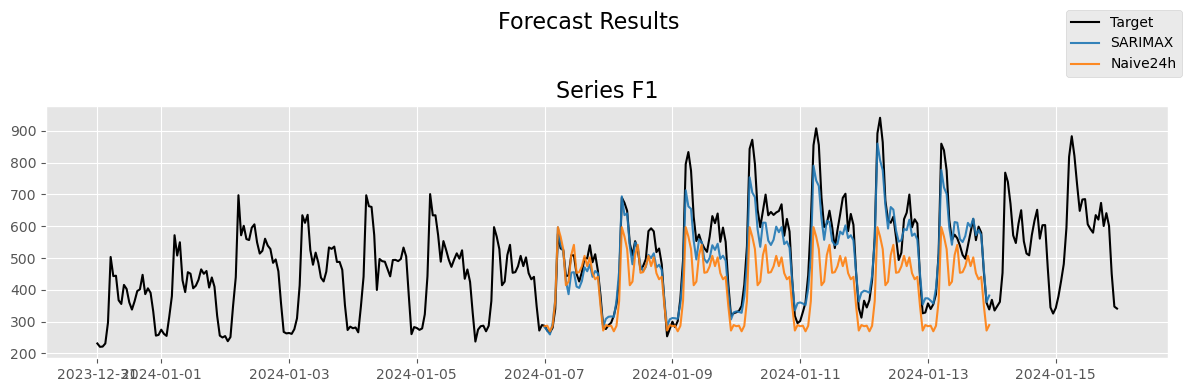

In [10]:
# Pick an id and a candidate threshold 
id = 'F1'

# Initialize configuration for the desired data preparation
sconfig = SARIMAXConfig(**sarimax_optimal_params[id])

# Create the SARIMAX pipeline with the specified configuration and generate the data
heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_id_df,
    config=sconfig,
    aux_df=aux_id_df,
)
spipeline.prepare_data()

# Fit the SARIMAX model
start_train = pd.Timestamp('2023-01-06 23:00:00')
end_train = pd.Timestamp('2024-01-06 23:00:00')
spipeline.fit(
    start_train=start_train,
    end_train=end_train,
)

# Generate forecasts and plot the results
forecasts = spipeline.predict(h=24*7)
custom_plot_results(
    target_df=heat_id_df,
    forecast_df=forecasts,
    start_offset=24*7,
    end_offset=24*2,
    with_naive=True,
    target_train_df=heat_id_df[heat_id_df['ds'] <= end_train],
)

In [32]:
forecasts

,SARIMAX,unique_id,ds
0,327.320,F1,2024-01-12 00:00:00
1,352.188,F1,2024-01-12 01:00:00
2,381.645,F1,2024-01-12 02:00:00
3,465.911,F1,2024-01-12 03:00:00
4,623.098,F1,2024-01-12 04:00:00
...,...,...,...
163,608.472,F1,2024-01-18 19:00:00
164,574.831,F1,2024-01-18 20:00:00
165,425.747,F1,2024-01-18 21:00:00
166,311.240,F1,2024-01-18 22:00:00


(49, 23)
(168, 23)


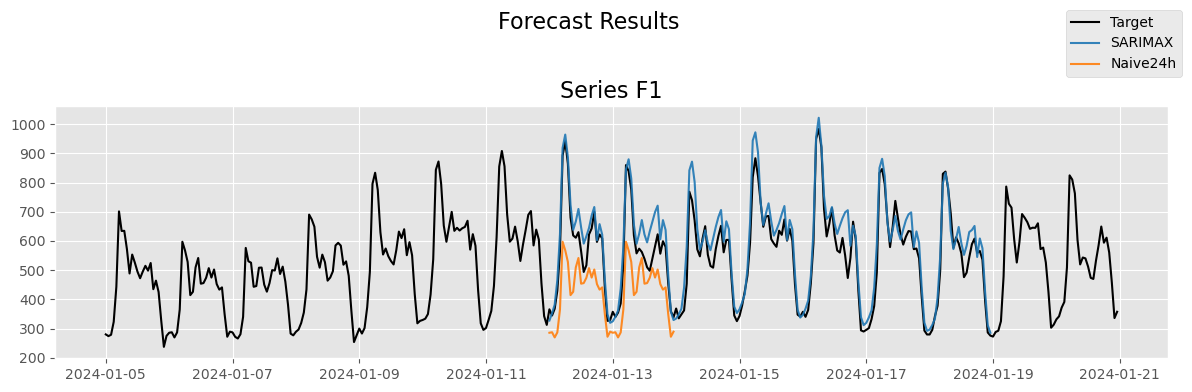

In [31]:
context_start = pd.Timestamp('2024-01-09 23:00:00')
context_end = pd.Timestamp('2024-01-11 23:00:00')
forecasts = spipeline.forward(
    context_start=context_start,
    context_end=context_end,
    h=24*7
)
custom_plot_results(
    target_df=heat_id_df,
    forecast_df=forecasts,
    start_offset=24*7,
    end_offset=24*2,
    with_naive=True,
    target_train_df=heat_id_df[heat_id_df['ds'] <= end_train],
)

00:40:22 | INFO | heat_forecast.pipeline.sarimax | Fitting SARIMAX model: start_train=2022-01-06 23:00:00, end_train=2024-01-06 23:00:00


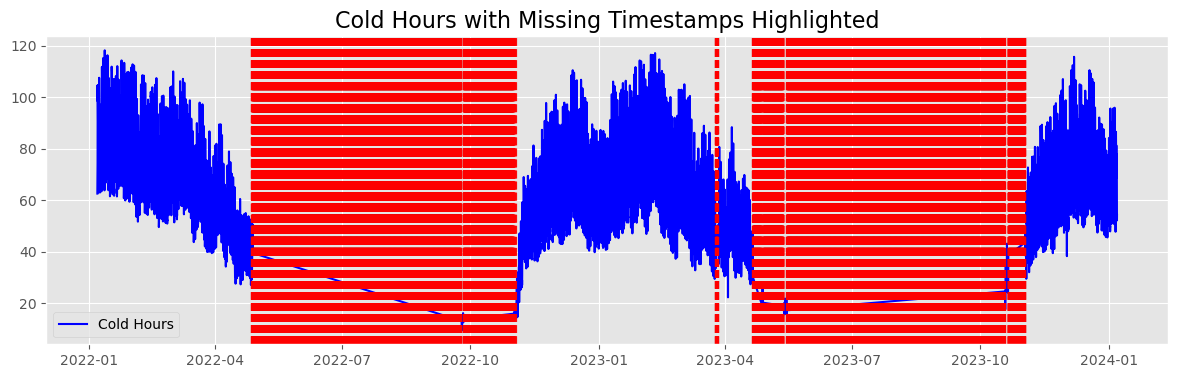

44 valid cold weeks found.
  unique_id                  ds      y  is_cold  sin1_168_cold  sin2_168_cold  \
0        F1 2000-01-03 00:00:00 69.929        1          0.000          0.000   
1        F1 2000-01-03 01:00:00 74.773        1          0.037          0.075   
2        F1 2000-01-03 02:00:00 75.525        1          0.075          0.149   
3        F1 2000-01-03 03:00:00 79.737        1          0.112          0.223   
4        F1 2000-01-03 04:00:00 93.310        1          0.149          0.295   

   sin3_168_cold  sin4_168_cold  sin5_168_cold  sin6_168_cold  ...  \
0         -0.000          0.000          0.000         -0.000  ...   
1          0.112          0.149          0.186          0.223  ...   
2          0.222          0.295          0.365          0.434  ...   
3          0.330          0.434          0.532          0.624  ...   
4          0.434          0.563          0.680          0.782  ...   

   cos6_168_cold  cos7_168_cold  temperature_1days_avg_cold  \
0 

00:41:15 | INFO | heat_forecast.pipeline.sarimax | ✓ SARIMAX model fitted successfully.


(17521, 23)
(168, 23)


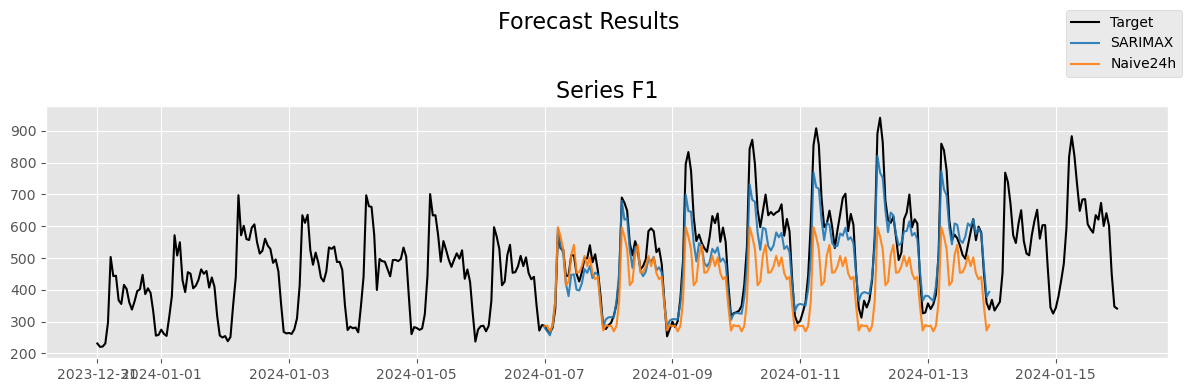

In [59]:
# Pick an id and a candidate threshold 
id = 'F1'

# Initialize configuration for the desired data preparation
params = sarimax_optimal_params[id].copy()
params['threshold'] = 15  # Example threshold
params['only_cold_data'] = True  # Use only cold data
sconfig = SARIMAXConfig(**params)

# Create the SARIMAX pipeline with the specified configuration and generate the data
heat_id_df = heat_df[heat_df['unique_id'] == id].copy()
aux_id_df = aux_df[aux_df['unique_id'] == id].copy()
spipeline = SARIMAXPipeline(
    target_df=heat_id_df,
    config=sconfig,
    aux_df=aux_id_df,
)
spipeline.prepare_data()

# Fit the SARIMAX model
start_train = pd.Timestamp('2022-01-06 23:00:00')
end_train = pd.Timestamp('2024-01-06 23:00:00')
spipeline.fit(
    start_train=start_train,
    end_train=end_train,
)

# Generate forecasts and plot the results
forecasts = spipeline.predict(h=24*7)
custom_plot_results(
    target_df=heat_id_df,
    forecast_df=forecasts,
    start_offset=24*7,
    end_offset=24*2,
    with_naive=True,
    target_train_df=heat_id_df[heat_id_df['ds'] <= end_train],
)